In [5]:
"""
We created a dataset with graphs of size 2^1,2^2,..,2^15,2^16. This data set is saved in //home/groups/ai/maskey/input_rad/processed. A graph of size n and constructed with radius r, can be read out by "DL.get(10*r,n)" after constructing the Data loader object, e.g. "DL = RGGDataset_grid(root = '../../input_rad')".

Then, we use the finest graph(size 2^16) as the continuous limit object and calculate graph wise l^2 errors with some graph signal. 

"""

import numpy as np
import torch
from torch_geometric.data import Data #for constructing data/graph objects from the sample points
import time

import random

import matplotlib.pyplot as plt

from torch_geometric.nn import SAGEConv #used for the model construction
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch.nn.functional as F

import sys
sys.path.insert(1,'../src')
from DataLoader_rad_grid import RGGDataset_grid #This is the class to load data
from TwoLayerGraphSage import GCN #This is our MPNN

import os.path as osp

from torch_geometric.data import Dataset, download_url

import os

import pickle #for saving

DL = RGGDataset_grid(root = '../../input_rad')

dataset = DL.get(1,2**5)

#load the positions, list of positions for all graphs
positions = torch.load('../../input_rad/raw/grid_positions_128.pt')

model = GCN()
model.load_state_dict(torch.load( '../models/GCNTwoLayersGraphSage'))

N = 14

def error_fct(radius, signal):
    """
    Calculates for a given radius and signal the error between the coarser graphs and finest graph
    
    """
    L2Errors = []

    cdata = DL.get(radius,2**N)
    cpos = positions[-1]

    cdata.x = signal 

    output = model.forward(cdata)

        
    for i in range(1, N):
        data = DL.get(radius, 2**i) 
        pos = positions[i-1]
        signal = cdata.x[pos[1].type(torch.LongTensor)]
        signal = torch.reshape(signal,( len(signal),1))
        data.x = signal + (1**0.5)*torch.randn(len(signal),1) #random noise

        nodeErrors = output[pos[1].type(torch.LongTensor)] - model.forward(data)
        L2Error = torch.sqrt(1/len(nodeErrors)*torch.sum(torch.pow(nodeErrors,2)))
        L2Errors.append(L2Error)

    err = [x.detach().numpy() for x in L2Errors]

    return err

errs = [ ]
#low_pass = lambda x:  (1+(torch.tensor(x[:,0]**2 + x[:,1]**2))).pow_(-1)
low_pass = lambda x:  x[:,0]*x[:,1]
#y = torch.randn(2**N,1)

cdata = DL.get(1,2**N)
cpos = positions[-1]
signal = low_pass(cpos[0])
signal = torch.reshape(signal,( len(signal),1))
#cdata.x = y 
#signal = y

for i in [1,5,9]:
    errs.append(error_fct(i, signal))
    
with open('../output/RandnNoiseMultSignalGraphSage2MLP' + str(2**14) + 'Nodes' + '.pickle', 'wb') as output:
    pickle.dump(errs, output)
    


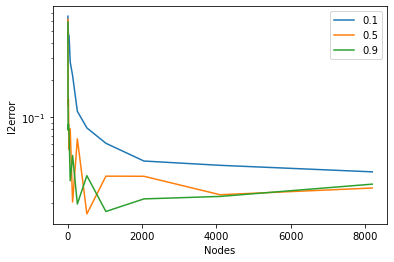

In [8]:
xAxis = [2**n for n in range(1,14)]
fig = plt.figure()
plt.xlabel('Nodes')
plt.ylabel('l2error')
plt.yscale('log')
#txt="radius: " + str((radius)/10)
#plt.figtext(0.5, 1, txt, wrap=True, horizontalalignment='center', fontsize=15)
plt.plot(xAxis,errs[0],label='0.1')
plt.plot(xAxis,errs[1], label='0.5')
plt.plot(xAxis,errs[2],label='0.9')
plt.legend()
fig.savefig('../output/RandnSignalGraphSage2MLPl2Error' + str(2**14) + 'Nodes.png', dpi=fig.dpi)




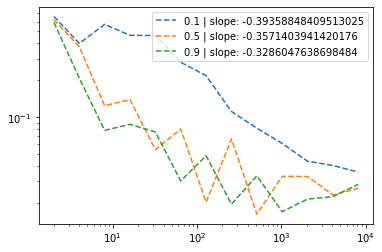

In [9]:
slope0, intercept0 = np.polyfit(np.log(xAxis), np.log(errs[0]), 1)
slope1, intercept1 = np.polyfit(np.log(xAxis), np.log(errs[1]), 1)
slope2, intercept2 = np.polyfit(np.log(xAxis), np.log(errs[2]), 1)


#txt="radius: " + str((radius)/10) + "  |  slope: " + str(slope)
#plt.figtext(0.5, 1, txt, wrap=True, horizontalalignment='center', fontsize=15)
plt.loglog(xAxis[:],errs[0], '--', label = '0.1 | slope: ' + str(slope0))
plt.loglog(xAxis[:],errs[1], '--', label = '0.5 | slope: ' + str(slope1))           
plt.loglog(xAxis[:],errs[2], '--', label = '0.9 | slope: ' + str(slope2))           
plt.legend()

fig.savefig('../output/RandnSignalGraphSage2MLPLogl2Error' + str(2**14) + 'Nodes.png', dpi=fig.dpi)


    
